# INITIALIZATION

In [1]:
import numpy as np
import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./tmp/data/", one_hot=True)

Extracting ./tmp/data/train-images-idx3-ubyte.gz
Extracting ./tmp/data/train-labels-idx1-ubyte.gz
Extracting ./tmp/data/t10k-images-idx3-ubyte.gz
Extracting ./tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
# Parameters
learning_rate = 0.1
num_steps = 500
batch_size = 128
display_step = 100

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
X = tf.placeholder("float", [None, num_input])
Y = tf.placeholder("float", [None, num_classes])

In [3]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [4]:
# Create model
def neural_net(x):
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    # Output fully connected layer with a neuron for each class
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

In [5]:
# Construct model
logits = neural_net(X)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

In [6]:
# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [7]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Save and Restore
saver = tf.train.Saver()

# SAVE VARIABLES

In [8]:
# Set value loading operations
def param_value_load_ops(param_tensor_list):
    """

    Args:
        param_tensor_list: list of trainable parameters

    Returns:
        load_ops_list: list of ops
        load_ph_list: list of placeholders
    """
    load_ops_list = []
    load_ph_list = []

    # For each parameter
    for param_tensor in param_tensor_list:
        # Make a copy of placeholder and load it
        param_load_ph = tf.placeholder(dtype=param_tensor.dtype,
                                       shape=param_tensor.shape)
        load_ph_list.append(param_load_ph)
        # Load ops with placeholder assigned to it
        load_ops_list.append(param_tensor.assign(param_load_ph))

    return load_ops_list, load_ph_list

In [9]:
# Start training
with tf.Session() as sess:
    # Run the initializer
    sess.run(init)
    
    # TODO: save initial weights and biases (using pickle?)
    w_init = sess.run(weights)
    b_init = sess.run(biases)
    init_param_value_list = []
    for key in ['h1', 'h2', 'out']:
        init_param_value_list.append(w_init[key])
    for key in ['b1', 'b2', 'out']:
        init_param_value_list.append(b_init[key])
    
    for step in range(1, num_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                                 Y: batch_y})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc))
            save_path = saver.save(sess, "./tmp/model.ckpt")
            print("Model saved in file: %s" % save_path)

    print("Optimization Finished!")

    # TODO: save trained weights and biases (using pickle)
    w_trnd = sess.run(weights)
    b_trnd = sess.run(biases)
    trnd_param_value_list = []
    for key in ['h1', 'h2', 'out']:
        trnd_param_value_list.append(w_trnd[key])
    for key in ['b1', 'b2', 'out']:
        trnd_param_value_list.append(b_trnd[key])

    # Calculate accuracy for MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: mnist.test.images,
                                      Y: mnist.test.labels}))
    
    # TODO: plot Accuracy for linear combiantion of initialized/trained weights and biases

Step 1, Minibatch Loss= 10860.5312, Training Accuracy= 0.281
Model saved in file: ./tmp/model.ckpt
Step 100, Minibatch Loss= 384.9174, Training Accuracy= 0.859
Model saved in file: ./tmp/model.ckpt
Step 200, Minibatch Loss= 117.8154, Training Accuracy= 0.852
Model saved in file: ./tmp/model.ckpt
Step 300, Minibatch Loss= 69.2436, Training Accuracy= 0.859
Model saved in file: ./tmp/model.ckpt
Step 400, Minibatch Loss= 46.7813, Training Accuracy= 0.844
Model saved in file: ./tmp/model.ckpt
Step 500, Minibatch Loss= 52.6807, Training Accuracy= 0.898
Model saved in file: ./tmp/model.ckpt
Optimization Finished!
('Testing Accuracy:', 0.85890001)


# RESTORE VARIABLES

In [10]:
# Get list of trainable parameters
param_tensor_list = tf.trainable_variables()

In [11]:
# Build load operation
load_ops_list, load_ph_list = param_value_load_ops(param_tensor_list)

# DO LINEAR COMBINATION AND EVALUATE

In [26]:
with tf.Session() as sess:
    sess.run(init)
    
    # linearly combine init and trained parameters
    alphas = np.arange(0.0,2.01,.05)
    errors = []
    for alpha in alphas:
        feed_dict = {}
        for load_ph, init_value, trnd_value in zip(load_ph_list, init_param_value_list, trnd_param_value_list):
            # linearly combine values
            feed_dict[load_ph] = init_value*(1.-alpha) + trnd_value*alpha

        sess.run(load_ops_list,
                 feed_dict=feed_dict)

        # do eval by using the graph
        # Calculate accuracy for MNIST test images
        acc = sess.run(accuracy, feed_dict={X: mnist.test.images,
                                            Y: mnist.test.labels})
        print("Testing Accuracy:", acc )
        errors.append(1-acc)

('Testing Accuracy:', 0.098999999)
('Testing Accuracy:', 0.15809999)
('Testing Accuracy:', 0.2624)
('Testing Accuracy:', 0.3854)
('Testing Accuracy:', 0.49779999)
('Testing Accuracy:', 0.57700002)
('Testing Accuracy:', 0.63190001)
('Testing Accuracy:', 0.67220002)
('Testing Accuracy:', 0.70599997)
('Testing Accuracy:', 0.7335)
('Testing Accuracy:', 0.75550002)
('Testing Accuracy:', 0.77630001)
('Testing Accuracy:', 0.7924)
('Testing Accuracy:', 0.81110001)
('Testing Accuracy:', 0.8272)
('Testing Accuracy:', 0.84289998)
('Testing Accuracy:', 0.85519999)
('Testing Accuracy:', 0.86470002)
('Testing Accuracy:', 0.87050003)
('Testing Accuracy:', 0.8689)
('Testing Accuracy:', 0.85890001)
('Testing Accuracy:', 0.82179999)
('Testing Accuracy:', 0.74470001)
('Testing Accuracy:', 0.6415)
('Testing Accuracy:', 0.5323)
('Testing Accuracy:', 0.4262)
('Testing Accuracy:', 0.33450001)
('Testing Accuracy:', 0.26190001)
('Testing Accuracy:', 0.2042)
('Testing Accuracy:', 0.162)
('Testing Accuracy:', 0.

# PLOT

In [20]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

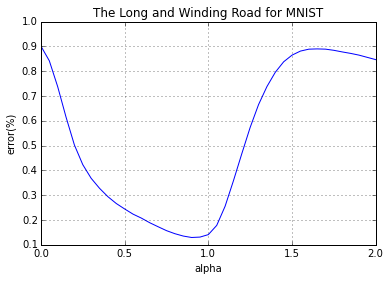

In [31]:
plt.plot(alphas, errors)

plt.xlabel('alpha')
plt.ylabel('error(%)')
plt.title('The Long and Winding Road for MNIST')
plt.grid(True)
# plt.savefig("mnist_journey.png")
plt.show()

# CHECK